In [1]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
import re
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='ticks', palette='Set2')
import sys
from tqdm.auto import tqdm
np.random.seed(42)
plt.style.use('ggplot')

In [2]:
sys.path.append('../utility')
from concordance_index import concordance_index
from regression_line import abline
from repeated_analysis import repeated_analysis
from cross_validate_random_forest import cross_validate_random_forest
from string_utils import multiple_replace
from norm import tpm

In [3]:
!pwd

/cluster/majf_lab/mtinti/extend_UTRs/ML/decoding-gene-expression/LD


In [4]:
df = pd.read_csv('ML_DATASET.csv.gz',index_col=[0])
df=df.dropna()
print(df.shape)
df.head()

(6026, 52)


,sequence_3p,sequence_5p,cds_seq,utr_3_count_A,utr_3_count_T,utr_3_count_C,utr_3_count_G,utr_3_count_AT,utr_3_count_CG,utr_3_count_CT,...,utr_5_count_tracts_CT_mismatch_0,utr_5_count_tracts_AG_mismatch_0,third_base_A,third_base_T,third_base_G,third_base_C,non_optimal_codon,ribo_counts,rna_counts,gene_length
LdBPK_365960.1,AGGCAGCCAGCGCACCTGTGATTGGCGTGCACGCCTCACGTGAGGC...,ACCTTCTCTTTCCATCCCAGCCCGTCGGCTCCCCGAGTGACCTGCT...,ATGGGGTTTTTAACCGTTTACAAGGGCGGTGAGCCGCCCAAGTCGA...,0.182419,0.237805,0.320630,0.259146,0.420224,0.579776,0.558435,...,0.026667,0.006667,0.026316,0.048872,0.127820,0.130326,0.142857,29,4,798
LdBPK_365970.1,AATGTGAAGAGCACAGCGCCTGCGGGCCACCAGCGGTGAACAACCT...,ATTCACTTTTCTCCTACCTCGTCCCCTCTCATGATGGCAACCCCGG...,ATGGGCAAGCGCACCAAGAAGGCCCCAAAGCAGAAGCGGAAACTCG...,0.126646,0.316109,0.308004,0.249240,0.442756,0.557244,0.624113,...,0.026667,0.026667,0.033708,0.037453,0.138577,0.123596,0.179775,60,13,267
LdBPK_365980.1,CGACTCGGTGCATGCGTGCGTGTGCGTGTCTTCTGTGTGGGGGGGG...,TCTTTCATTTCTCCCGGCGACGGCAGTACGTTGACAGCGTGTGCCA...,ATGCACAGCGTCAGCTTGGCCGGACTTTGCGCTGAGCTCTCGCGAA...,0.210024,0.205251,0.288783,0.295943,0.415274,0.584726,0.494033,...,0.033333,0.000000,0.038633,0.038633,0.134720,0.121347,0.181278,12,13,2019
LdBPK_365990.1,CCTGTCGTGCGGTGCGAGGAGCGCGCCAGTACGTGGAGCTCGTCAC...,TTGTCGAGGGGAGGAGGAAGCGAGTAACAGACAACCCTCAGCAAGT...,ATGTACATGGATATTCTGGAACAGGAGGTGGAGCACCTCAGTGCTG...,0.152355,0.263158,0.351801,0.232687,0.415512,0.584488,0.614958,...,0.040000,0.020000,0.054945,0.045330,0.117216,0.115842,0.239011,15,44,2184
LdBPK_366000.1,AGCAGCCGTGGCGACGCCCTGTCACACGATGGGTGGCAGGCAGGTC...,GATCTCCCTTCTCGGGTGTCCCATCCCTCCCGCCTTCTCGCTCTCT...,ATGAACCTCGATCAACTGTCGCAGTTTCTCGCCACGGTAGTGCGCC...,0.155419,0.265849,0.319018,0.259714,0.421268,0.578732,0.584867,...,0.033333,0.006667,0.036221,0.046011,0.121880,0.129222,0.161527,52,15,2043


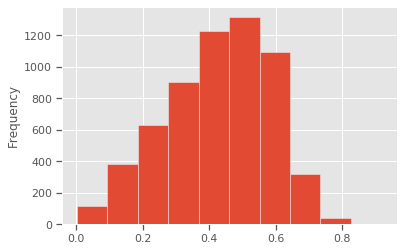

In [5]:
counts_column=['ribo_counts','rna_counts']
targets = tpm(df[counts_column], df['gene_length'])
targets['TE']=targets['ribo_counts']/(
    targets['rna_counts']+targets['ribo_counts'])
targets['TE'].plot(kind='hist')

In [6]:
df[['TE','ribo_counts','rna_counts']]=targets[['TE','ribo_counts','rna_counts']]

In [7]:
#df = df.drop(['RIBO_SRR1272136','RIBO_SRR1272137','RIBO_SRR1272138']+['RNA_SRR1272145','RNA_SRR1272146','RNA_SRR1272147']+['Length'],axis=1)

In [8]:
df['5p_ATG']=[n.count('ATG') for n in df['sequence_5p']]

In [9]:
df['log_mean_ribo']=np.log10(df['ribo_counts'])
df['log_mean_rna']=np.log10(df['rna_counts'])

In [10]:
del df['rna_counts']
del df['ribo_counts']

In [11]:
df[['log_mean_ribo','log_mean_rna','TE','sequence_3p']+['sequence_3p','utr_3_count_A', 'utr_3_count_T', 'utr_3_count_C', 'utr_3_count_G',
      'third_base_A', 'third_base_T', 'third_base_G', 'third_base_C']].to_csv('viz_dataset.csv.gz')

In [12]:
#np.array(df.columns)

In [13]:
to_drop = ['TE', 'sequence_3p', 'sequence_5p', 'cds_seq', 'log_mean_ribo', 'log_mean_rna', 'gene_length']
print(len(to_drop))
to_drop = [n for n in to_drop if n in list(df.columns)]
print(len(to_drop))


7
7


In [14]:
print(df.shape)
df=df.replace(-np.inf,np.nan)
df=df.replace(np.inf,np.nan)
df=df.dropna()
df.shape

(6026, 54)


(6026, 54)

In [15]:
cor_matrix = df.drop(to_drop, axis=1).corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
corr_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(corr_to_drop)

['utr_3_count_CG', 'utr_3_count_AG', 'utr_3_count_tracts_A_mismatch_1', 'utr_3_count_tracts_C_mismatch_1', 'utr_3_count_tracts_CT_mismatch_1', 'utr_3_count_tracts_AG_mismatch_1', 'utr_3_count_tracts_A_mismatch_0', 'utr_3_count_tracts_C_mismatch_0', 'utr_3_count_tracts_AG_mismatch_0', 'utr_5_count_CG', 'utr_5_count_AG', 'utr_5_count_tracts_A_mismatch_1', 'utr_5_count_tracts_C_mismatch_1', 'utr_5_count_tracts_CT_mismatch_1', 'utr_5_count_tracts_AG_mismatch_1', 'utr_5_count_tracts_A_mismatch_0', 'utr_5_count_tracts_C_mismatch_0', 'utr_5_count_tracts_AG_mismatch_0']


In [16]:
#X.shape

In [17]:
X=df.drop(to_drop, axis=1).drop(corr_to_drop, axis=1)
y=df['log_mean_rna']

In [18]:
results = cross_validate_random_forest(X, y, n_splits=3)

all_predictions = results['predictions']
all_true_values = results['true_values']
regr = results['model']
fold_metrics = results['fold_metrics']
X_train, y_train = results['train_data']
X_test, y_test = results['test_data']

Fold 1 - R2: 0.3402, RMSE: 0.3404
Fold 2 - R2: 0.3499, RMSE: 0.3356
Fold 3 - R2: 0.3543, RMSE: 0.3484

Overall Metrics:
Mean R2: 0.3481 ± 0.0072
Mean RMSE: 0.3415 ± 0.0065


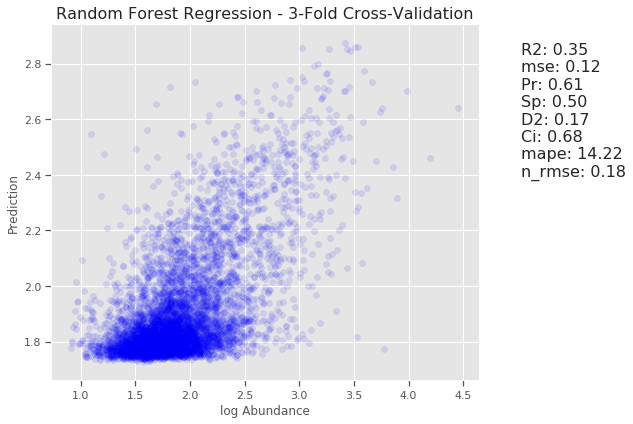

In [19]:
# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(all_true_values, all_predictions, c='blue', alpha=0.1)
abline(all_true_values, all_predictions, ax, text_loc = [1.1, 0.95])
ax.set_ylabel('Prediction')
ax.set_xlabel('log Abundance')
ax.set_title('Random Forest Regression - 3-Fold Cross-Validation',fontsize=16)
plt.tight_layout()
plt.show()

In [20]:
oof_df = pd.DataFrame()
oof_df['oof_mRNAabundance']=all_predictions

In [21]:
    
feature_names = [multiple_replace(n) for n in list(X_test.columns)]

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


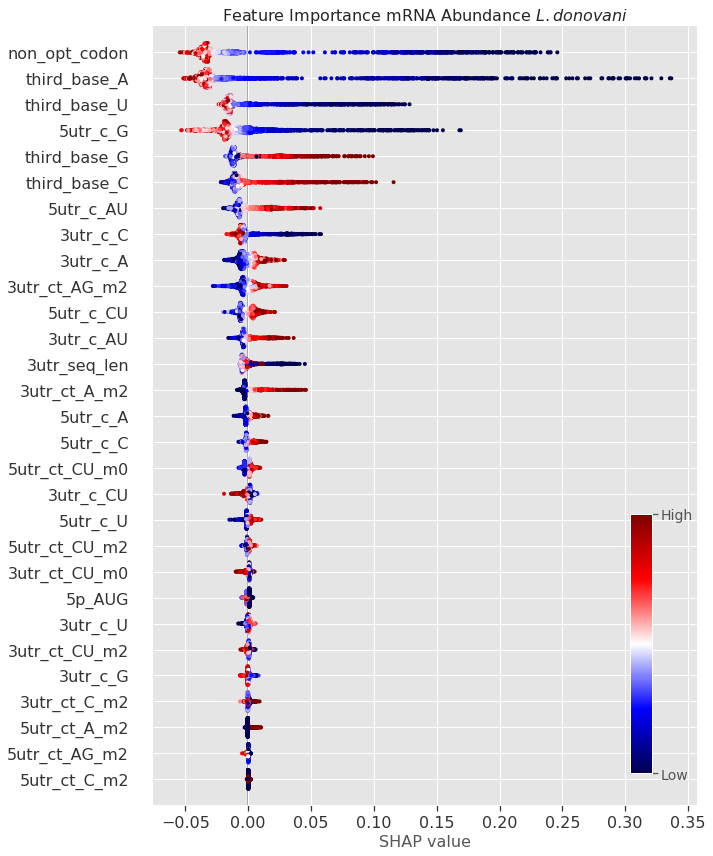

In [22]:
import shap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

# Now we use the SHAP scoring system to visualise 
# the most important features for the model
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_test)

# Create the SHAP summary plot
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=feature_names,
                  max_display=50, show=False, color_bar=False)

# Get the current figure and axes
f = plt.gcf()
f.set_size_inches(10, 12)
ax = plt.gca()

# Customize the plot
plt.title('Feature Importance mRNA Abundance $\it{L. donovani}$', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('SHAP value', fontsize=16)

my_cmap = plt.get_cmap('seismic')

# Change the colormap of the artists
for child in ax.get_children():
    if hasattr(child, "set_cmap"):
        child.set_cmap(my_cmap)

# Create the colorbar and adjust its size
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cbar_ax = f.add_axes([0.88, 0.1, 0.03, 0.3])
cbar = f.colorbar(cm.ScalarMappable(norm=norm, cmap='seismic'), cax=cbar_ax, shrink=0.5)
cbar.set_ticks([-1, 1])
cbar.set_ticklabels(['Low', 'High'])
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig('UTR_seismic_LD_MRNA_abundance.png')
plt.savefig('UTR_seismic_LD_MRNA_abundance.svg')

In [23]:
#shap.summary_plot??

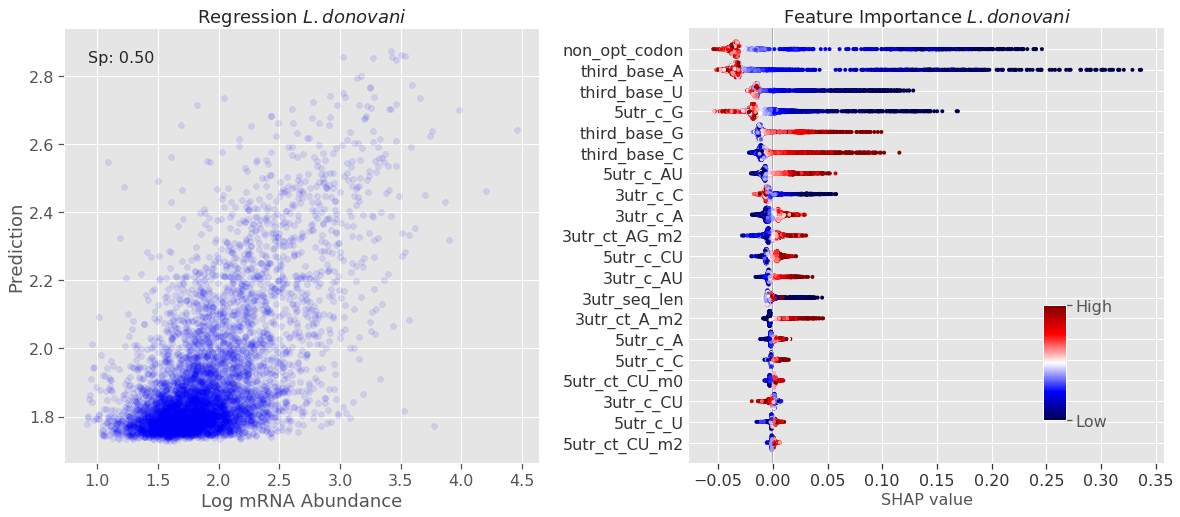

In [24]:

fig = plt.figure(figsize=(16, 8))
# Increase right margin to accommodate colorbar
plt.subplots_adjust(left=0.1, right=0.85)  # Adjusted right margin

# Create gridspec without the colorbar position
gs = fig.add_gridspec(1, 2, width_ratios=[0.45, 0.45], wspace=0.4)
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
plt.rcParams.update({'font.size': 16})

# First plot (scatter plot)
axes[0].scatter(all_true_values, all_predictions, c='blue', alpha=0.1)
abline(all_true_values, all_predictions, axes[0], visualize = ['Sp'])
axes[0].set_ylabel('Prediction', fontsize=18)
axes[0].set_xlabel('Log mRNA Abundance', fontsize=18)
axes[0].set_title('Regression $\it{L. donovani}$', fontsize=18)
axes[0].tick_params(axis='both', labelsize=16)

# Simple seismic colorbar first
my_cmap = plt.get_cmap('seismic')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

# SHAP plot in the middle
plt.sca(axes[1])  
shap.summary_plot(shap_values, 
                 X_test, 
                 feature_names=feature_names,
                 max_display=20, show=False, plot_size=(16,8), color_bar=False)
axes[1].tick_params(axis='both', labelsize=16)  
axes[1].set_title('Feature Importance $\it{L. donovani}$', fontsize=18)
axes[1].set_xlabel('SHAP value', fontsize=16)

# Apply colormap
for fc in fig.get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"): 
            fcc.set_cmap(my_cmap)

# Adjust positions manually for main plots
pos0 = axes[0].get_position()
pos1 = axes[1].get_position()
axes[0].set_position([pos0.x0, pos0.y0, pos0.width+0.1, pos0.height])
axes[1].set_position([pos1.x0+0.105, pos1.y0, pos1.width+0.1, pos1.height])
axes[1].tick_params(axis='y', pad=-15)
# Add colorbar after adjusting main plots
cax = fig.add_axes([0.95, 0.2, 0.02, 0.2])  # [left, bottom, width, height]
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=my_cmap, norm=norm)
cb.set_ticks([-1, 1])
cb.set_ticklabels(['Low', 'High'])
cb.ax.tick_params(labelsize=16)


plt.savefig('Ld_mRNA_Abundance.png', bbox_inches='tight', dpi=300)
plt.savefig('Ld_mRNA_Abundance.svg', bbox_inches='tight')
plt.show()

In [25]:
results_df = repeated_analysis(X, y)
results_df['analysis_sp']='LD'
results_df['analysis_type']='Abundance_All'
results_df.to_csv('stats_LD_Abundance_All.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))

only_utr = [n for n in list(X.columns) if n.startswith('utr_')]
only_codon = [n for n in list(X.columns) if not n.startswith('utr_')]
results_df = repeated_analysis(X[only_utr], y)
results_df['analysis_sp']='LD'
results_df['analysis_type']='Abundance_utr'
results_df.to_csv('stats_LD_Abundance_utr.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))

results_df = repeated_analysis(X[only_codon], y)
results_df['analysis_sp']='LD'
results_df['analysis_type']='Abundance_codon'
results_df.to_csv('stats_LD_Abundance_codon.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))



  0%|          | 0/100 [00:00<?, ?it/s]

Average Sp: 0.4926 ± 0.0165


  0%|          | 0/100 [00:00<?, ?it/s]

Average Sp: 0.2620 ± 0.0188


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]

Average Sp: 0.4661 ± 0.0151


In [26]:
X=df.drop(to_drop, axis=1).drop(corr_to_drop, axis=1)
y=df['TE']

Fold 1 - R2: 0.2595, RMSE: 0.1342
Fold 2 - R2: 0.2612, RMSE: 0.1311
Fold 3 - R2: 0.2585, RMSE: 0.1350

Overall Metrics:
Mean R2: 0.2597 ± 0.0014
Mean RMSE: 0.1334 ± 0.0021


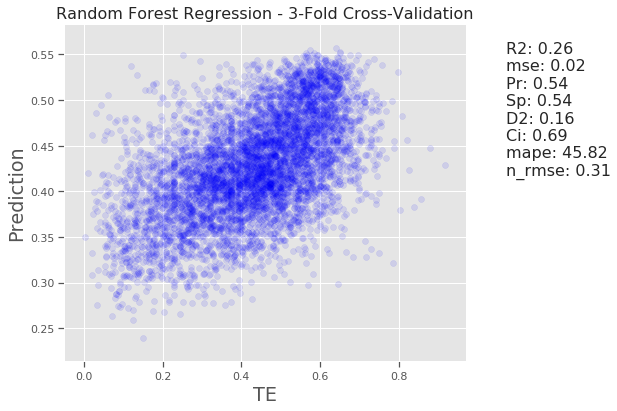

In [27]:
# Assuming X is a pandas DataFrame and y is a pandas Series
#all_predictions, all_true_values, regr, X_train, X_test, y_train, y_test = cross_validate_random_forest(X, y)
results = cross_validate_random_forest(X, y, n_splits=3)

# Access components from results dictionary
all_predictions = results['predictions']
all_true_values = results['true_values']
regr = results['model']
fold_metrics = results['fold_metrics']
X_train, y_train = results['train_data']
X_test, y_test = results['test_data']



# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(all_true_values, all_predictions , c='blue', alpha=0.1)
abline(all_true_values, all_predictions, ax, text_loc = [1.1, 0.95])
ax.set_ylabel('Prediction')
ax.set_xlabel('TE')
ax.set_title('Random Forest Regression - 3-Fold Cross-Validation',fontsize=16)
plt.tight_layout()
plt.show()


In [28]:
oof_df['oofs_TE']=all_predictions

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


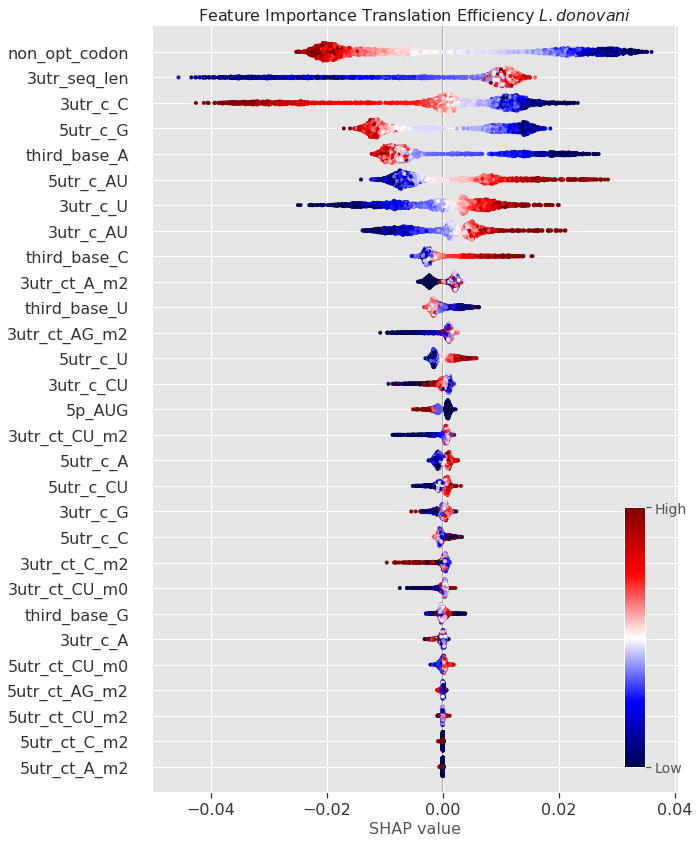

In [29]:
import shap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

# Now we use the SHAP scoring system to visualise 
# the most important features for the model
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_test)

# Create the SHAP summary plot
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=feature_names,
                  max_display=50, show=False, color_bar=False)

# Get the current figure and axes
f = plt.gcf()
f.set_size_inches(10, 12)
ax = plt.gca()

# Customize the plot
plt.title('Feature Importance Translation Efficiency $\it{L. donovani}$', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('SHAP value', fontsize=16)

my_cmap = plt.get_cmap('seismic')

# Change the colormap of the artists
for child in ax.get_children():
    if hasattr(child, "set_cmap"):
        child.set_cmap(my_cmap)

# Create the colorbar and adjust its size
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cbar_ax = f.add_axes([0.88, 0.1, 0.03, 0.3])
cbar = f.colorbar(cm.ScalarMappable(norm=norm, cmap='seismic'), cax=cbar_ax, shrink=0.5)
cbar.set_ticks([-1, 1])
cbar.set_ticklabels(['Low', 'High'])
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig('UTR_seismic_LD_TE.png')
plt.savefig('UTR_seismic_LD_TE.svg')

In [30]:
feature_names = [multiple_replace(n) for n in list(X_test.columns)]

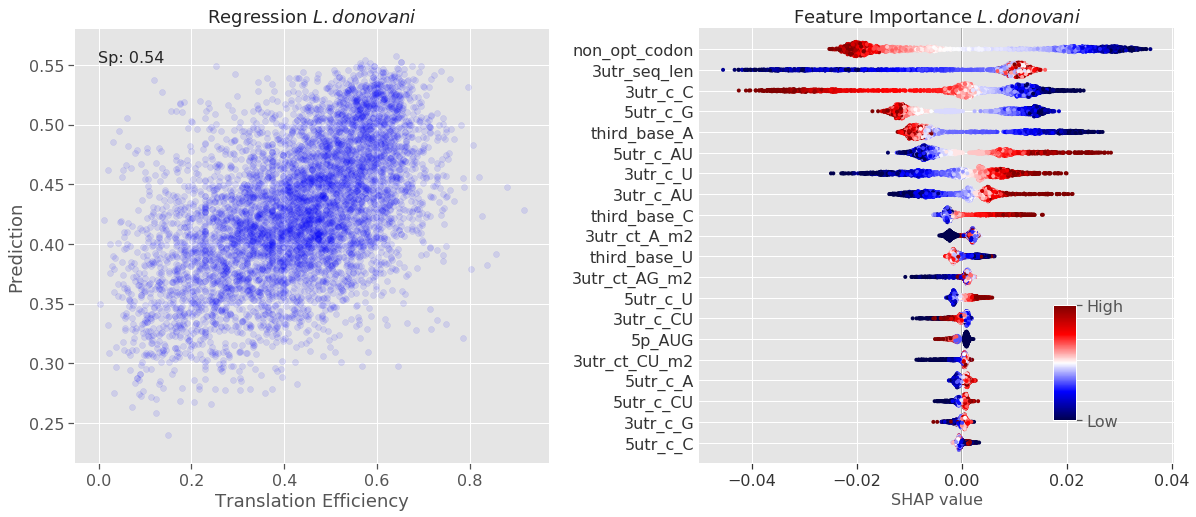

In [31]:

fig = plt.figure(figsize=(16, 8))
# Increase right margin to accommodate colorbar
plt.subplots_adjust(left=0.1, right=0.85)  # Adjusted right margin

# Create gridspec without the colorbar position
gs = fig.add_gridspec(1, 2, width_ratios=[0.45, 0.45], wspace=0.4)
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
plt.rcParams.update({'font.size': 16})

# First plot (scatter plot)
axes[0].scatter(all_true_values, all_predictions, c='blue', alpha=0.1)
abline(all_true_values, all_predictions, axes[0], visualize = ['Sp'])
axes[0].set_ylabel('Prediction', fontsize=18)
axes[0].set_xlabel('Translation Efficiency', fontsize=18)
axes[0].set_title('Regression $\it{L. donovani}$', fontsize=18)
axes[0].tick_params(axis='both', labelsize=16)

# Simple seismic colorbar first
my_cmap = plt.get_cmap('seismic')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

# SHAP plot in the middle
plt.sca(axes[1])  
shap.summary_plot(shap_values, 
                 X_test, 
                 feature_names=feature_names,
                 max_display=20, show=False, plot_size=(16,8), color_bar=False)
axes[1].tick_params(axis='both', labelsize=16)  
axes[1].set_title('Feature Importance $\it{L. donovani}$', fontsize=18)
axes[1].set_xlabel('SHAP value', fontsize=16)

# Apply colormap
for fc in fig.get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"): 
            fcc.set_cmap(my_cmap)

# Adjust positions manually for main plots
pos0 = axes[0].get_position()
pos1 = axes[1].get_position()
axes[0].set_position([pos0.x0, pos0.y0, pos0.width+0.1, pos0.height])
axes[1].set_position([pos1.x0+0.105, pos1.y0, pos1.width+0.1, pos1.height])

axes[1].tick_params(axis='y', pad=-15)
# Add colorbar after adjusting main plots
cax = fig.add_axes([0.95, 0.2, 0.02, 0.2])  # [left, bottom, width, height]
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=my_cmap, norm=norm)
cb.set_ticks([-1, 1])
cb.set_ticklabels(['Low', 'High'])
cb.ax.tick_params(labelsize=16)


plt.savefig('Ld_TE.png', bbox_inches='tight', dpi=300)
plt.savefig('Ld_TE.svg', bbox_inches='tight')
plt.show()

In [32]:
results_df = repeated_analysis(X, y)

100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


In [33]:
results_df['analysis_sp']='LD'
results_df['analysis_type']='TE_All'
results_df.to_csv('stats_LD_TE_All.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))

Average Sp: 0.5369 ± 0.0148


In [34]:
only_utr = [n for n in list(X.columns) if n.startswith('utr_')]
only_codon = [n for n in list(X.columns) if not n.startswith('utr_')]

results_df = repeated_analysis(X[only_utr], y)
results_df['analysis_sp']='LD'
results_df['analysis_type']='TE_utr'
results_df.to_csv('stats_LD_TE_utr.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))

results_df = repeated_analysis(X[only_codon], y)
results_df['analysis_sp']='LD'
results_df['analysis_type']='TE_codon'
results_df.to_csv('stats_LD_TE_codon.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))


  0%|          | 0/100 [00:00<?, ?it/s]

Average Sp: 0.4626 ± 0.0144


100%|██████████| 100/100 [01:15<00:00,  1.33it/s]

Average Sp: 0.3962 ± 0.0172


In [35]:
# show versions of packages
# adopted from https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
import pkg_resources
import types
import sys
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]
        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name.lower()
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
modules = []
for m in sys.builtin_module_names:
    if m.lower() in imports and m !='builtins':
        modules.append((m,'Python BuiltIn'))
        imports.remove(m.lower())

for m in pkg_resources.working_set:
    if m.project_name.lower() in imports and m.project_name!="pip":
        modules.append((m.project_name, m.version))
        imports.remove(m.project_name.lower())

for m in sys.modules:
    if m.lower() in imports and m !='builtins':
        modules.append((m,'unknown'))

# print('System=='+platform.system()+' '+platform.release()+'; Version=='+platform.version())
for r in modules:
    print("{}=={}".format(*r))

sys==Python BuiltIn
tqdm==4.36.1
shap==0.35.0
seaborn==0.9.0
scipy==1.3.2
scikit-learn==0.22
pandas==0.25.2
numpy==1.17.3
matplotlib==3.1.1
types==unknown
re==unknown
pkg_resources==unknown
concordance_index==unknown
repeated_analysis==unknown
cross_validate_random_forest==unknown
norm==unknown


In [36]:
#conda create -n ml_utr python=3.8 matplotlib=3.5.1 numpy=1.21.6 \
#scipy=1.10.1 pandas=1.4.2 scikit-learn=1.0.2 shap=0.39.0 \
#eli5=0.13.0 seaborn=0.11.2 jupyterlab numba=0.53
#conda activate ml_utr
#jupyter lab

In [37]:
#df['non_optimal_codon'].plot(kind='hist',bins=50)